In [153]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
from matplotlib import pyplot as plt
from pandasql import sqldf
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

# Premier League Season 2020/21 compared to previous seasons


The database was downloaded from Kaggle and contained five different tables related to various data from the English Premier League(EPL) spanning from its first season in 1992/93 to the recently concluded 2020/21 Season. In this database, there are scores of all matches in the EPL - including the major events of each match. There is also a database of all the players to ever play in the tournament. The First step in analysis of this data involved significant cleaning and manipulation of this data based. A visual inspection of the <em>fixed_stats</em> table showed that there were numerous blank rows that needed to be dropped from the table.

In [154]:
stats_messy = pd.read_csv('fixed_stats.csv')

print(stats_messy.head(4))

   possession_%_home  possession_%_away  shots_on_target_home  \
0               53.2               46.8                     8   
1                0.0                0.0                     0   
2               62.4               37.6                    11   
3                0.0                0.0                     0   

   shots_on_target_away  shots_home  shots_away  touches_home  touches_away  \
0                     2          23           7           643           523   
1                     0           0           0             0             0   
2                     4          35           6           743           542   
3                     0           0           0             0             0   

   passes_home  passes_away  ...  corners_away  offsides_home  offsides_away  \
0          433          377  ...             3              3              1   
1            0            0  ...             0              0              0   
2          542          329  ...      

As we can see, there are numerous rows where there are no values. We need to inspect this data and clean it before it can be used for our analysis. As each match has a unique <b>match_id</b> associated with it, we can look for the <b>match_id</b> column value being 0 in our DataFrame to get an estimate of how many valid rows are in our DataFrame.

In [103]:
#find all instances of match_id being 0
match_id_is_zero = (stats_messy['match_id'] == 0)
non_empty_stats = stats_messy[((match_id_is_zero) == False).values]

non_empty_stats.reset_index(inplace = True)
non_empty_stats = non_empty_stats.drop(columns = (['index']))


Now we have cleaned up the empty rows and have a data set of match stats from 2006/07 season to the present season as the source of data, www.premierleague.com, only provides these detailed data from that season onwards. This is how our cleaned match stats looks like:

In [104]:
print(non_empty_stats.head(2))

   possession_%_home  possession_%_away  shots_on_target_home  \
0               53.2               46.8                     8   
1               62.4               37.6                    11   

   shots_on_target_away  shots_home  shots_away  touches_home  touches_away  \
0                     2          23           7           643           523   
1                     4          35           6           743           542   

   passes_home  passes_away  ...  corners_away  offsides_home  offsides_away  \
0          433          377  ...             3              3              1   
1          542          329  ...             1              0              4   

   yellow_cards_home  yellow_cards_away  fouls_conceded_home  \
0                  2                  1                   12   
1                  0                  1                   13   

   fouls_conceded_away  match_id  red_cards_home  red_cards_away  
0                    9    5597.0               0               0 

In the Premier League, teams have traditionally been stronger when they play in their home stadium as compared to when they play in their opponent's stadium. Teams have won leagues building their home stadium as fortress and better teams in the league often go whole season undefeated ( each team plays 19 home games and 19 away games) in their home games. As a result, we would expect each season to have more home wins than away wins for each team - and thus, the cumulative home win and away win for the season should also reflect higher ratio of home wins.

We will now explore the ratio of home win per away win for all seasons. We will first do an exploratory analysis of these statistics to see if anything stands out from the norm.


The <em>clean_games</em> file used below to populate the records of home wins, losses and draws comes from the kaggle dataset which in turn had been scraped from the official Premier League website.

In [105]:
df_games = pd.read_csv('clean_games.csv')

results =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM df_games
    WHERE (df_games.home_score > df_games.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM df_games
    WHERE (df_games.home_score < df_games.away_score)
    GROUP BY season
""")



results['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM df_games
    WHERE (df_games.home_score = df_games.away_score)
    GROUP BY season
""")

results['draw'] = draws['draw']

results['total']= results['home_win']+results['away_win']+ results['draw']

print(results.head(30))

     season  home_win  away_win  draw  total
0   1992/93       214       118   130    462
1   1993/94       192       128   142    462
2   1994/95       205       123   134    462
3   1995/96       186        96    98    380
4   1996/97       162        99   119    380
5   1997/98       184       101    95    380
6   1998/99       169        96   115    380
7   1999/00       187       101    92    380
8   2000/01       184        95   101    380
9   2001/02       165       114   101    380
10  2002/03       187       103    90    380
11  2003/04       167       105   108    380
12  2004/05       173        97   110    380
13  2005/06       192       111    77    380
14  2006/07       182       100    98    380
15  2007/08       176       104   100    380
16  2008/09       173       110    97    380
17  2009/10       193        91    96    380
18  2010/11       179        90   111    380
19  2011/12       171       116    93    380
20  2012/13       166       106   108    380
21  2013/1

Let us plot the line graph of the home_win, away_win, and draw for each season to visualize these numbers. However, as the total number of games is different for different seasons, we will work with the proportion (i.e. home_win/total, away_win/total, draw/total for each season to visualize a standardized ratio of the three possible outcomes for each season.

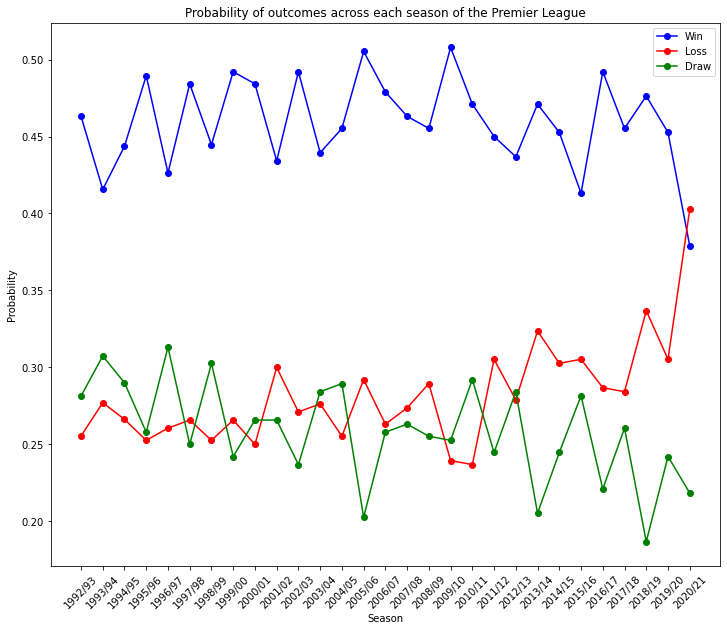

In [106]:
def draw_line_chart(results, legends):
    plt.close('all')
    plt.figure(figsize = (12, 10))
    plt.plot(results['season'], results['home_win']/results['total'], color = 'blue', marker = 'o')
    plt.plot(results['season'], results['away_win']/results['total'], color = 'red', marker = 'o')
    plt.plot(results['season'], results['draw']/results['total'], color = 'green', marker = 'o')

    plt.title('Probability of outcomes across each season of the Premier League')
    plt.ylabel('Probability')
    plt.xlabel('Season')

    plt.xticks(rotation = 45)
    plt.legend(legends)
    plt.show()
    
draw_line_chart(results, ['Win', 'Loss', 'Draw'])

This is an interesting observation for the 2020/21 season. Here we can see that the probability of home win dropped visibly in the 2020/2021 season, while the probability of away win significantly rose from around 30% in the previous years to the 40% range. In fact, this was a peculiar season where there were more away wins than home wins - as well as the most number of away wins across all seasons - even including the 462 game seasons.

Almost all of the matches were played without spectators for the duration of the 2020/2021 season due to the COVID-19 pandemic. We will explore what aspects of the game changed that caused this observation.

We will begin by performing an independent sample t-test of a few observations from the match statistics data to determine whether this observation is statistically significant.

## Dividing Stats and Games data into two groups : pre-2020 data and 2020/21 data

The <em>non_empty_stats</em> dataframe includes stats from matches ranging from the first season of the Premier League up to the latest season. We will now sample a few variables from this dataset - by diving this dataset as pre-2020 season dataset and 2020-season dataset to see if there is a significant difference in these two sample populations.

We will look at whether the ball possession and total shots per game stats for home and away teams have changed significantly in the pandemic year. Most importantly, we will see the goalscoring trends of home and away teams before and during the 2020/21 season.

Let us begin by performing the descriptive analysis of these variables. We will be looking at possession and shot statistics for home and away team as these are most directly associated with a team's strong performance. Teams that keep ball possession longer and take more shots usually have a higher likelihood of winning the game.


In [107]:
match_id_2020_season = []

for index, row in df_games.iterrows():
    if row['season'] == '2020/21':
        match_id_2020_season.append(int(row['match_id']))

In [108]:
stats_2020 = pd.DataFrame(columns = non_empty_stats.columns)
stats_pre_2020 = pd.DataFrame(columns = non_empty_stats.columns)

for index, row in non_empty_stats.iterrows():
    if row['match_id'] in match_id_2020_season:
        stats_2020 = stats_2020.append(row)
    else:
        stats_pre_2020 = stats_pre_2020.append(row)

At this point, the stats from the matches have been broken down in two samples - one containing all stats before the 2020/21 season and the second containing the stats from the 2020/21 season. We are ready to analyze whether the variables we are interested in are significantly different in these two samples.

In [109]:
# This function takes two series as input as outputs a side by side normalized histogram of those series

def draw_hist(fig1, fig2):
    plt.close('all')
    plt.figure(figsize=(9, 7))

    plt.subplot(1, 2, 1)
    plt.hist(fig1, bins=range(int(min(fig1))-5, int(max(fig1))+5, math.ceil((int(max(fig1))-int(min(fig1)))/20)), density = True)


    plt.subplot(1,2,2)
    plt.hist(fig2, bins=range(int(min(fig2))-5, int(max(fig2))+5, math.ceil((int(max(fig2))-int(min(fig2)))/20)), density = True)
    

    return plt.show()

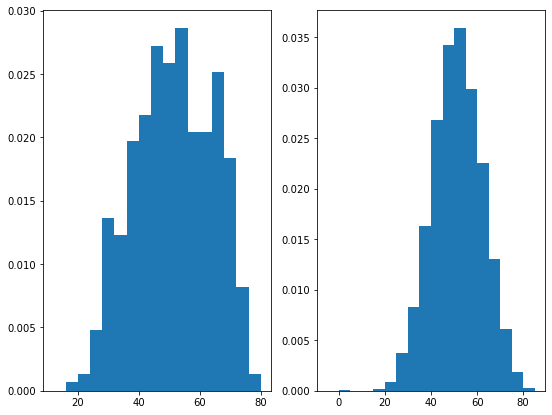

In [110]:
draw_hist(stats_2020['possession_%_home'], stats_pre_2020['possession_%_home'])

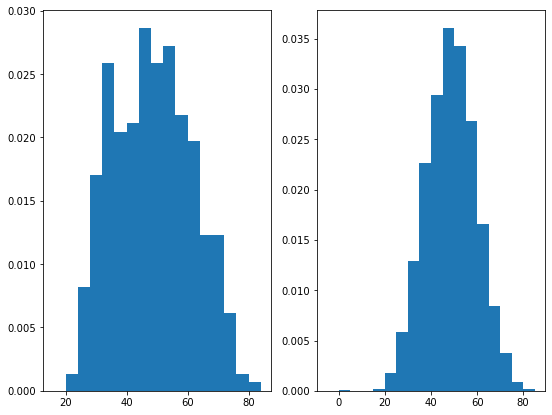

In [111]:
draw_hist(stats_2020['possession_%_away'], stats_pre_2020['possession_%_away'])

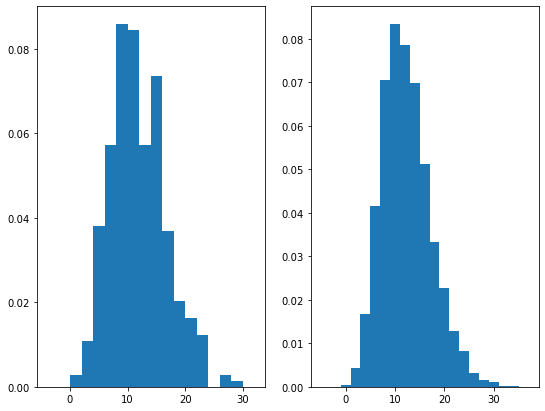

In [112]:
draw_hist(stats_2020['shots_away'], stats_pre_2020['shots_away'])

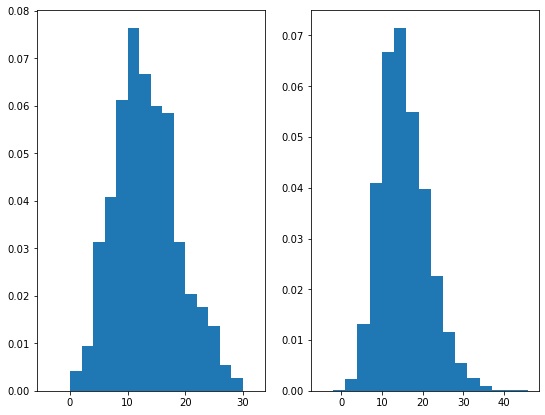

In [113]:
draw_hist(stats_2020['shots_home'], stats_pre_2020['shots_home'])

These four data pairs look normally distributed and are suitable candidates for further inferential analysis in order for us to examine whether there is a significant difference in these samples prior to the 2020 season and during the 2020 season.

We will create a function that takes two series as input and outputs the results of independent sample t-test to determine whether there is grounds for us to reject the null hypothesis.

In [114]:
def ttest_independent( first_sample, second_sample, labels):
    result = stats.ttest_ind(first_sample, second_sample, equal_var = False)
    
    try:
        print("""
            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            """)
        plt.close('all')
        plt.figure()
        data = [first_sample.mean(), second_sample.mean()]
            
        first_sample_df = pd.DataFrame(first_sample)
        first_sample_err = stats.sem(first_sample_df)
            
            
        second_sample_df = pd.DataFrame(second_sample)
        second_sample_err = stats.sem(second_sample_df)
            
        error = [first_sample_err[0], second_sample_err[0]]
        plt.bar( range(len(data)), data, yerr = error , color = ['blue', 'orange'], capsize = 5, alpha = 0.2)
        plt.ylim(min(data[0]- error[0], data[1] - error[1]) - 1, max(data[0]+ error[0], data[1] +error[1]) + 1 )
        
        for index,data in enumerate(data):
            plt.text(x=index , y = (round(data, 2) + error[1]), s=f"{round(data, 2)}")
            
        ax = plt.subplot()
        ax.set_xticks([0, 1])
        ax.set_xticklabels(labels)
        
        
            
        if (result.pvalue < 0.05):
            print(("""
            We reject the null hypothesis as p-value of {} is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            """).format(round(result.pvalue, 6)))
            
            
        else:
            print(("""
            We cannot reject the null hypothesis as p-value of {} is greater than the threshold 0.05 value.
            """).format(round(result.pvalue, 6)))
    except:
        print("""
            Please check the input variables and re-run the function.
        """)


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We cannot reject the null hypothesis as p-value of 0.076479 is greater than the threshold 0.05 value.
            


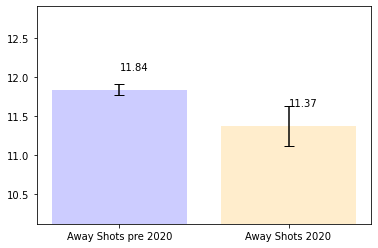

In [115]:
ttest_independent(stats_pre_2020['shots_away'], stats_2020['shots_away'], ["Away Shots pre 2020", 'Away Shots 2020'])

While on the first look it seems like away teams are taking less shots in the 2020 season, the data is not significant enough - hence, there is no basis for us to claim as such. Thus, in general, even in the past 2020/21 season, away teams are taking as many shots per goal as they normally do.


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 0.0 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


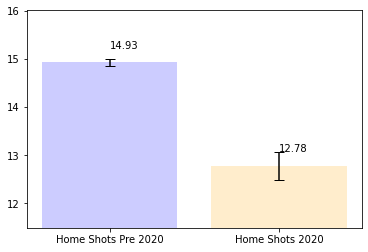

In [116]:
ttest_independent(stats_pre_2020['shots_home'], stats_2020['shots_home'], ['Home Shots Pre 2020', 'Home Shots 2020'])

This test shows a marked difference in the amount of shots taken by home team per game. They are taking 2 less shots per game than they normally do. As they are taking less number of shots, their probability of scoring also goes down thus causing them to lose matches.


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We cannot reject the null hypothesis as p-value of 0.956765 is greater than the threshold 0.05 value.
            


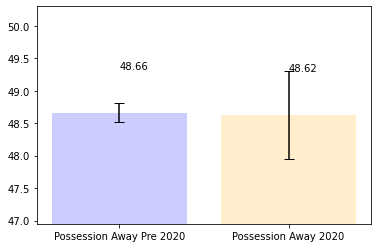

In [117]:
ttest_independent(stats_pre_2020['possession_%_away'], stats_2020['possession_%_away'], ['Possession Away Pre 2020', 'Possession Away 2020'])

There is no significance difference in the possession by the away teams before and during the 2020 season thus suggesting that, by interpolation, home teams are keeping a similar level of ball possession. This suggests us that despite the home team keeping the same amount of possession as compare to previous years, they are just taking fewer number of shots. They simply have been not creative enough - for a lack of shots without a change in possession stats suggests a lack of creativity by a team.


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We cannot reject the null hypothesis as p-value of 0.913025 is greater than the threshold 0.05 value.
            


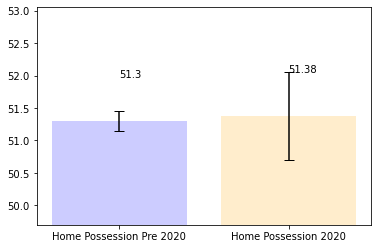

In [118]:
ttest_independent(stats_pre_2020['possession_%_home'], stats_2020['possession_%_home'], ['Home Possession Pre 2020', 'Home Possession 2020'])

As suspected, home teams are also maintaining the similar amount of ball possession as compared to the away teams. They are simply not taking as many shots as they used to.

# Further breaking the data by groups of team and seasond

As this primary analysis shows, home teams are taking significantly less shots per game during the 2020 season
despite the possession statistics remaining more or less same, as well as away teams maintaining shots and possession stats similar to the previous seasons. This leads us to ask ourselves whether this decrease in performance is spread across all teams in the division or just to particular teams.

English Premier League sends top 4 teams each season to compete in the Champions League, the most prestigious club competition in soccer with a very generous payout for the participating teams. As a result, the race for top 4 in the league is very competitive and the teams that make it to the top 4 are generally a notch higher over other teams. Similarly, bottom 3 teams in the League are relegated to the second division, strictly impacting their revenue for the next year. 

We will now look at the performances of the home and away performances of the teams in this two brackets before and during the pandemic season and explore whether there is a marked difference in the performance level.

Let us begin by analyzing the performances of bottom three i.e. the relegated teams from before the 2020 season and the 2020 season.

Note: To divide the data into 4 groups - Relegated Teams before and during the pandemic and Top Four teams before and during the pandemic, a DataFrame was created that contained a list of seasons from 2006 to 2021 along with a corresponding list of top 4 and bottom 3 teams each season. Then their stats were copied from the <em>non_empty_stats</em> dataframe that was created at the beginning of this workbook. Because this is a long and tedious process even for a fast processor, the results were saved to an excel file so they won't have to be tabulated every time this notebook is run. The codes for this operation are included in a second notebook for reference purposes.

In [119]:
relegated_2020 = pd.read_excel('bottom_home_2020.xlsx')
relegated_pre_2020 = pd.read_excel('bottom_home_pre_2020.xlsx')

In [120]:
results_relegated_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM relegated_2020
    WHERE (relegated_2020.home_score > relegated_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM relegated_2020
    WHERE (relegated_2020.home_score < relegated_2020.away_score)
    GROUP BY season
""")



results_relegated_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM relegated_2020
    WHERE (relegated_2020.home_score = relegated_2020.away_score)
    GROUP BY season
""")

results_relegated_2020['draw'] = draws['draw']

results_relegated_2020['total']= results_relegated_2020['home_win']+results_relegated_2020['away_win']+ results_relegated_2020['draw']

In [121]:
print(results_relegated_2020)

    season  home_win  away_win  draw  total
0  2020/21        10        36    11     57


In [122]:
results_relegated_pre_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM relegated_pre_2020
    WHERE (relegated_pre_2020.home_score > relegated_pre_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM relegated_pre_2020
    WHERE (relegated_pre_2020.home_score < relegated_pre_2020.away_score)
    GROUP BY season
""")



results_relegated_pre_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM relegated_pre_2020
    WHERE (relegated_pre_2020.home_score = relegated_pre_2020.away_score)
    GROUP BY season
""")

results_relegated_pre_2020['draw'] = draws['draw']

results_relegated_pre_2020['total']= results_relegated_pre_2020['home_win']+results_relegated_pre_2020['away_win']+ results_relegated_pre_2020['draw']

     season  home_win  away_win  draw  total
0   2006/07        17        20    20     57
1   2007/08         7        18    13     38
2   2008/09        17        21    19     57
3   2009/10        18        25    14     57
4   2010/11        16        23    18     57
5   2011/12        16        33     8     57
6   2012/13        10        25    22     57
7   2013/14        16        27    14     57
8   2014/15        15        25    17     57
9   2015/16        15        25    17     57
10  2016/17        15        27    15     57
11  2017/18        14        26    17     57
12  2018/19        14        35     8     57
13  2019/20        15        27    15     57
0   2020/21        10        36    11     57


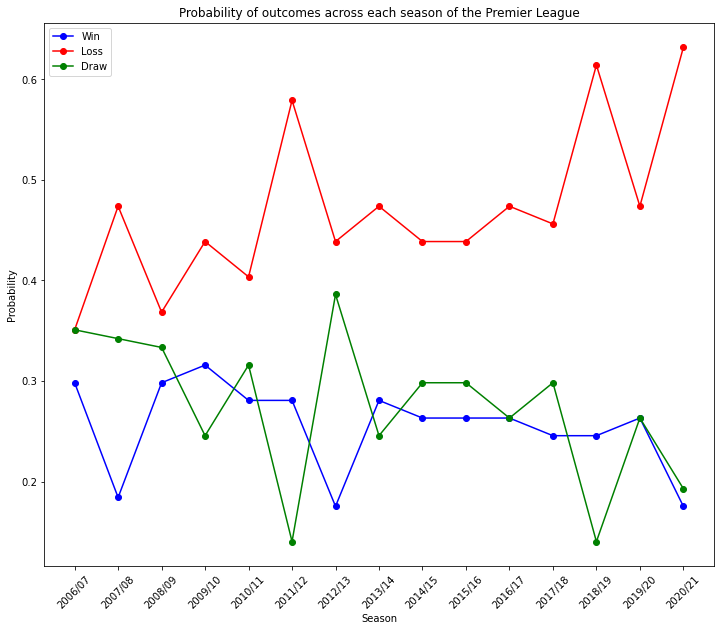

In [123]:
united_relegated_results = results_relegated_pre_2020.append(results_relegated_2020)
united_relegated_results = united_relegated_results.reindex()
print(united_relegated_results)

draw_line_chart(united_relegated_results, ['Win', 'Loss', 'Draw'])

The line chart above and the table it is based on paint a compelling picture of how the 2020/21 season was the 
worst for the relegated teams at home. They won a combined 10 games all season at home, and lost 36 games - the joint-worst win record tied with the 2012/13 season - as well as the loss record from all seasons.

This supports our observation that teams have generally performed below standards in their home grounds and relegated teams were particularly bad in the 2020/21 season. 

Let us perform a t-test of the goals scored by the relegated teams in 2020/21 season as compared to the goals scored in other seasons combined to see if there is a significant difference in the amount of goals scored.


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We cannot reject the null hypothesis as p-value of 0.619608 is greater than the threshold 0.05 value.
            


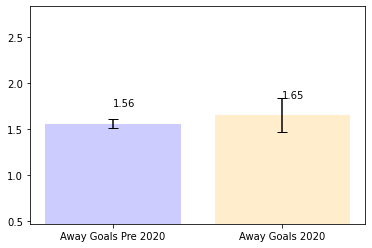

In [124]:
ttest_independent(relegated_pre_2020['away_score'], relegated_2020['away_score'], ['Away Goals Pre 2020', 'Away Goals 2020'])


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 4.3e-05 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


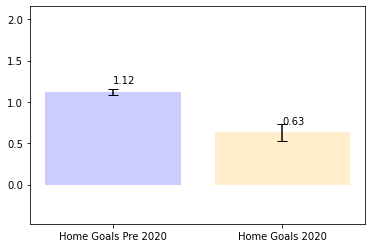

In [125]:
ttest_independent(relegated_pre_2020['home_score'], relegated_2020['home_score'], ['Home Goals Pre 2020', 'Home Goals 2020'])

These two t-test provide a very clear picture yet how the relaegated teams had a forgetful 2020/21 home season where their expected mean goals score dropped from 1.12 goals per game to 0.63 goals per game whereas the expected mean goals conceded stayed the same.

It is therefore, a direct consequence of the relegated teams scoring a lot less home games that they lost a record 36 games played in their home stadium.


Let us perform a t-test of the goals scored by the top four teams in the 2020/21 season as compared to the goals scored in other seasons combined to see if there is a significant difference in the amount of goals scored and conceded by the top teams at home stadium.

In [126]:
top_2020 = pd.read_excel('top_home_2020.xlsx')
top_pre_2020 = pd.read_excel('top_home_pre_2020.xlsx')

In [127]:
results_top_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM top_2020
    WHERE (top_2020.home_score > top_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM top_2020
    WHERE (top_2020.home_score < top_2020.away_score)
    GROUP BY season
""")



results_top_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM top_2020
    WHERE (top_2020.home_score = top_2020.away_score)
    GROUP BY season
""")

results_top_2020['draw'] = draws['draw']

results_top_2020['total'] = results_top_2020['home_win']+ results_top_2020['away_win']+ results_top_2020['draw']   

In [128]:
print(results_top_2020)

    season  home_win  away_win  draw  total
0  2020/21        41        20    15     76


In [129]:
results_top_pre_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM top_pre_2020
    WHERE (top_pre_2020.home_score > top_pre_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM top_pre_2020
    WHERE (top_pre_2020.home_score < top_pre_2020.away_score)
    GROUP BY season
""")



results_top_pre_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM top_pre_2020
    WHERE (top_pre_2020.home_score = top_pre_2020.away_score)
    GROUP BY season
""")

results_top_pre_2020['draw'] = draws['draw']

results_top_pre_2020['total']= results_top_pre_2020['home_win']+results_top_pre_2020['away_win']+ results_top_pre_2020['draw']

     season  home_win  away_win  draw  total
0   2006/07        53         4    19     76
1   2007/08        55         2    19     76
2   2008/09        50         6    20     76
3   2009/10        62         8     6     76
4   2010/11        56         8    12     76
5   2011/12        58         8    10     76
6   2012/13        53        10    13     76
7   2013/14        61         5    10     76
8   2014/15        55         7    14     76
9   2015/16        46        12    18     76
10  2016/17        57         5    14     76
11  2017/18        56         5    15     76
12  2018/19        59         7    10     76
13  2019/20        54         9    13     76
0   2020/21        41        20    15     76


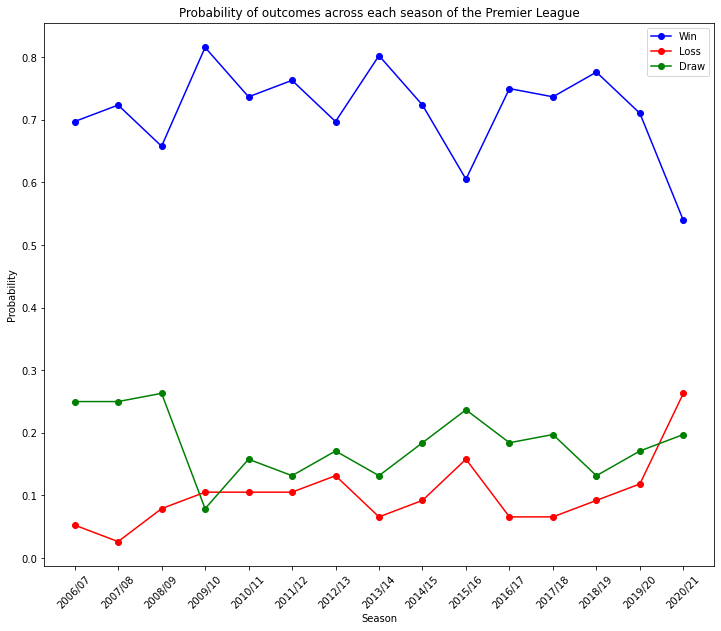

In [130]:
results_top = results_top_pre_2020.append(results_top_2020)

print(results_top)

draw_line_chart(results_top, ['Win', 'Loss', 'Draw'])

Just as with relegated team stats, the top 4 teams also had a forgettable home record for the 2020/21 season. Their tally of 41 wins from 76 games is the lowest figure of all years and their 20 home losses is significantly higher than the second closest 12 home losses in the 2015/16 season. Top 4 teams rarely lost so many home games as the 2020/21 season. 

Let us explore further to understand what could have cause such reversal of fortunes for the top 4 teams.


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 0.03001 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


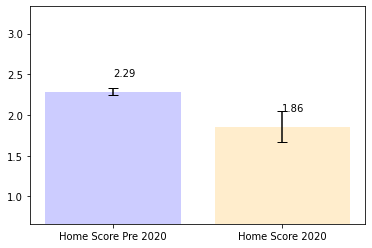

In [131]:
ttest_independent(top_pre_2020['home_score'], top_2020['home_score'], ['Home Score Pre 2020', 'Home Score 2020'])


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 0.023607 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


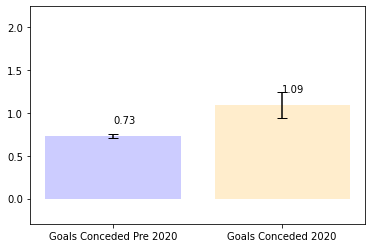

In [132]:
ttest_independent(top_pre_2020['away_score'], top_2020['away_score'], ['Goals Conceded Pre 2020','Goals Conceded 2020'])

Just as with the relegated teams, once again, the top 4 teams are also scoring significantly less goals in home and conceding significantly more goals. Teams simply are scoring less and conceding more at home which explains why the 2020/21 season saw the number of away wins higher than the number of home wins for the first time in the history of the Premier League.

In [133]:

bottom_awaystats_pre_2020 = pd.read_excel('bottom_awaystats_pre_2020.xlsx')
top_awaystats_pre_2020= pd.read_excel('top_awaystats_pre_2020.xlsx')

bottom_awaystats_2020 = pd.read_excel('bottom_awaystats_2020.xlsx')
top_awaystats_2020 = pd.read_excel('top_awaystats_2020.xlsx')

bottom_homestats_pre_2020 = pd.read_excel('bottom_homestats_pre_2020.xlsx')
top_homestats_pre_2020 = pd.read_excel('top_homestats_pre_2020.xlsx')

bottom_homestats_2020 = pd.read_excel('bottom_homestats_2020.xlsx')
top_homestats_2020 = pd.read_excel('top_homestats_2020.xlsx')




            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 5.3e-05 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


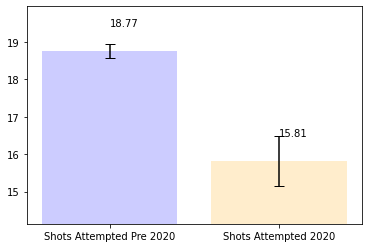

In [134]:
ttest_independent(top_homestats_pre_2020['shots_home'], top_homestats_2020['shots_home'], ['Shots Attempted Pre 2020', 'Shots Attempted 2020'])


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We cannot reject the null hypothesis as p-value of 0.563015 is greater than the threshold 0.05 value.
            


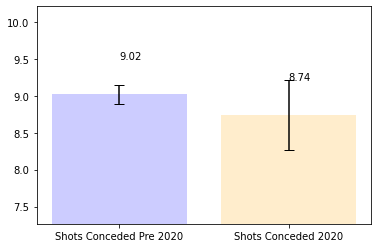

In [135]:
ttest_independent(top_homestats_pre_2020['shots_away'], top_homestats_2020['shots_away'], ['Shots Conceded Pre 2020', 'Shots Conceded 2020'])

As we can see from the above t-tests, top 4 teams are taking significantly less shots and conceding about the same number of shots from opponents while they play at home. This decrease in the amount of shots per game by top 4 teams explains why the average goal per game of top teams decrease from 2.29 to 1.86 per games.

This begs an interesting question : if teams across the division at the top as well as bottom are performing poorly at home, which of these groups of teams is performing strongly as an away team? Are both groups of top 4 teams as well as bottom relegated teams performing better away from home?



            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 0.00029 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


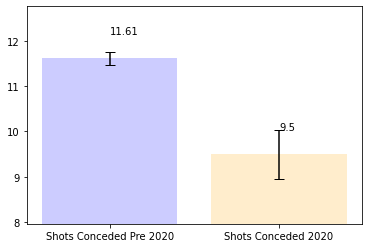

In [136]:
ttest_independent(top_awaystats_pre_2020['shots_home'], top_awaystats_2020['shots_home'], ['Shots Conceded Pre 2020', 'Shots Conceded 2020'])


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We cannot reject the null hypothesis as p-value of 0.152073 is greater than the threshold 0.05 value.
            


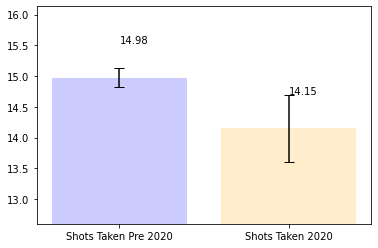

In [137]:
ttest_independent(top_awaystats_pre_2020['shots_away'], top_awaystats_2020['shots_away'], ['Shots Taken Pre 2020', 'Shots Taken 2020'])


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 1e-05 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


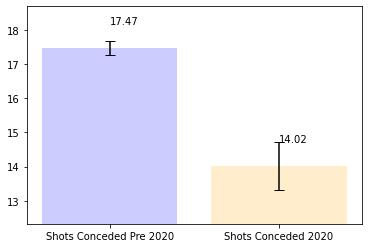

In [138]:
ttest_independent(bottom_awaystats_pre_2020['shots_home'], bottom_awaystats_2020['shots_home'], ['Shots Conceded Pre 2020', 'Shots Conceded 2020'])


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We cannot reject the null hypothesis as p-value of 0.054598 is greater than the threshold 0.05 value.
            


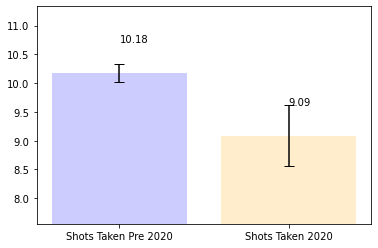

In [139]:
ttest_independent(bottom_awaystats_pre_2020['shots_away'], bottom_awaystats_2020['shots_away'], ['Shots Taken Pre 2020', 'Shots Taken 2020'])

It is clear from the above four t-tests that while top 4 teams are taking similar number of shots in each away game, they are restricting their opposition from shooting in their goals from an average of 11.6 shots to 9.5 per game.
The same is true for relegated teams. While they are shooting less ( 10.18 shots per game before 2020 season to 9.09 shots per game, although the p-value at 0.054 is greater than the 0.05 threshold), they are also facing lot less shots per game in their away games (17.47 shots conceded pre pandemic to 14.02 during the 2020/21 season). Let us see how these statistics result in goals statistics as well as win-loss statistics for top 4 teams as well as relegated teams for 2020/21 season in their away games.

In [140]:
relegated_away_2020 = pd.read_excel('bottom_away_2020.xlsx')
relegated_away_pre_2020 = pd.read_excel('bottom_away_pre_2020.xlsx')

top_away_2020 = pd.read_excel('top_away_2020.xlsx')
top_away_pre_2020 = pd.read_excel('top_away_pre_2020.xlsx')

In [141]:
results_top_away_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM top_away_2020
    WHERE (top_away_2020.home_score > top_away_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM top_away_2020
    WHERE (top_away_2020.home_score < top_away_2020.away_score)
    GROUP BY season
""")



results_top_away_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM top_away_2020
    WHERE (top_away_2020.home_score = top_away_2020.away_score)
    GROUP BY season
""")

results_top_away_2020['draw'] = draws['draw']

results_top_away_2020['total'] = results_top_away_2020['home_win']+ results_top_away_2020['away_win']+ results_top_away_2020['draw'] 



In [142]:
results_top_away_pre_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM top_away_pre_2020
    WHERE (top_away_pre_2020.home_score > top_away_pre_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM top_away_pre_2020
    WHERE (top_away_pre_2020.home_score < top_away_pre_2020.away_score)
    GROUP BY season
""")



results_top_away_pre_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM top_away_pre_2020
    WHERE (top_away_pre_2020.home_score = top_away_pre_2020.away_score)
    GROUP BY season
""")

results_top_away_pre_2020['draw'] = draws['draw']

results_top_away_pre_2020['total']= results_top_away_pre_2020['home_win']+results_top_away_pre_2020['away_win']+ results_top_away_pre_2020['draw']

     season  home_win  away_win  draw  total
0   2006/07        22        38    16     76
1   2007/08        13        42    21     76
2   2008/09        11        48    17     76
3   2009/10        24        36    16     76
4   2010/11        22        28    26     76
5   2011/12        21        39    16     76
6   2012/13        15        41    20     76
7   2013/14        20        41    15     76
8   2014/15        18        37    21     76
9   2015/16        14        35    27     76
10  2016/17        16        44    16     76
11  2017/18        16        45    15     76
12  2018/19        19        47    10     76
13  2019/20        23        42    11     76
0   2020/21        10        46    20     76


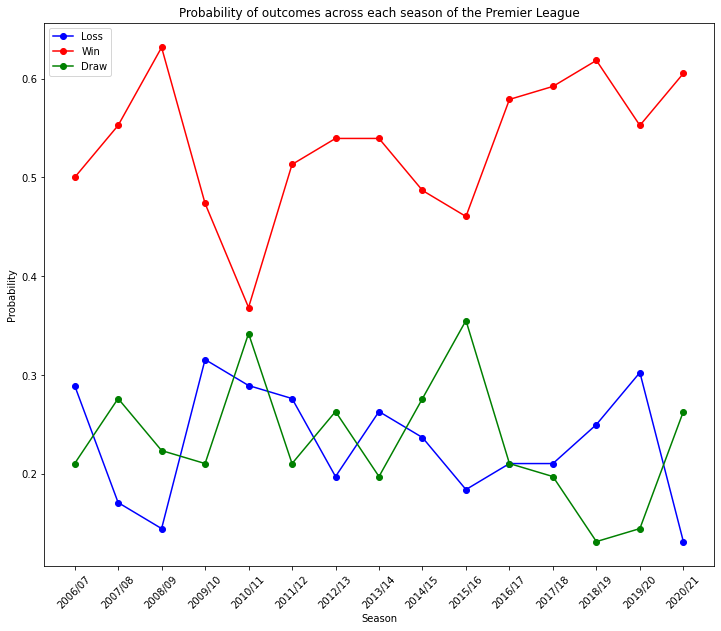

In [143]:
results_top_away = results_top_away_pre_2020.append(results_top_away_2020)

print(results_top_away)

draw_line_chart(results_top_away, ['Loss', 'Win', 'Draw'])

In [144]:
results_relegated_away_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM relegated_away_2020
    WHERE (relegated_away_2020.home_score > relegated_away_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM relegated_away_2020
    WHERE (relegated_away_2020.home_score < relegated_away_2020.away_score)
    GROUP BY season
""")



results_relegated_away_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM relegated_away_2020
    WHERE (relegated_away_2020.home_score = relegated_away_2020.away_score)
    GROUP BY season
""")

results_relegated_away_2020['draw'] = draws['draw']

results_relegated_away_2020['total'] = results_relegated_away_2020['home_win']+ results_relegated_away_2020['away_win']+ results_relegated_away_2020['draw'] 




In [145]:
results_relegated_away_pre_2020 =sqldf( """
    SELECT season, count(*) as 'home_win'
    FROM relegated_away_pre_2020
    WHERE (relegated_away_pre_2020.home_score > relegated_away_pre_2020.away_score)
    GROUP BY season
""")


away = sqldf("""
    SELECT count(*) as 'away_win'
    FROM relegated_away_pre_2020
    WHERE (relegated_away_pre_2020.home_score < relegated_away_pre_2020.away_score)
    GROUP BY season
""")



results_relegated_away_pre_2020['away_win']= away['away_win']



draws = sqldf(
"""
    SELECT count(*) as draw
    FROM relegated_away_pre_2020
    WHERE (relegated_away_pre_2020.home_score = relegated_away_pre_2020.away_score)
    GROUP BY season
""")

results_relegated_away_pre_2020['draw'] = draws['draw']

results_relegated_away_pre_2020['total']= results_relegated_away_pre_2020['home_win']+results_relegated_away_pre_2020['away_win']+ results_relegated_away_pre_2020['draw']

     season  home_win  away_win  draw  total
0   2006/07        40         6    11     57
1   2007/08        30         2     6     38
2   2008/09        39         5    13     57
3   2009/10        43         3    11     57
4   2010/11        30         9    18     57
5   2011/12        29        15    13     57
6   2012/13        38         9    10     57
7   2013/14        40         8     9     57
8   2014/15        37         8    12     57
9   2015/16        43         6     8     57
10  2016/17        41         5    11     57
11  2017/18        33         7    17     57
12  2018/19        43         6     8     57
13  2019/20        42         7     8     57
0   2020/21        35         7    15     57


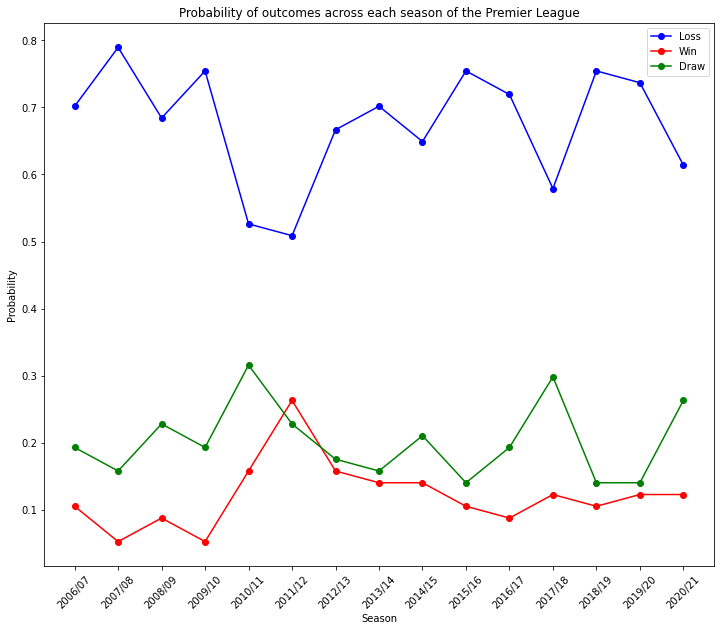

In [146]:
results_relegated_away = results_relegated_away_pre_2020.append(results_relegated_away_2020)

print(results_relegated_away)

draw_line_chart(results_relegated_away, ['Loss', 'Win', 'Draw'])

As we can see, the probability of away loss halved for the top four teams in the 2020/21 season compared to the previous 2019/20 season. In fact, top teams lost the least amount of away games in the 2020/21 season than any other season.

# Conclusion

We began by a cursory observation of the Premier League statistics for each season since its inception. When we plotted the total number of home wins, away wins and draws statistics of all season, we found out how 2020/21 season stood out from all other seasons. It was the first time in the history of the Premier League that the away teams won more than home teams.

We sought to find out the causes that contributed to this event. As there were no spectators for almost all of the 2020/21 season due to the COVID-19 pandemic - this might have been the biggest contributor that led to more away wins than home wins in the 2020/21 season. We broke down the performances of the home team and the away team for the Four Top and Three Relegated teams each season to explore what aspects of their games were impacted or changed in the 2020/21 season. 

We failed to reject the null hypothesis in regards to the possession statistics as well as shots on goals by away teams for both population group i.e. these statistics had not significantly changed during the pandemic season as compared to the previous seasons. However, for both groups, the amount of shots they took each game in their home games had dropped significantly.

As the more shots a team takes, the greater the probability of the team scoring and winning the matches, it is no wonder that home teams performed a lot worse in 2020/21 season as they became shot shy. One factor we could check to corroborate our conclusion would be to check the total home and away scores for the 2020/21 season compared to previous years. We expect to see roughly the same amount of away goals in the 2020/21 season as compared to the previous seasons but expect home goals to be significantly lower.



In [147]:
goals_data =sqldf( """
    SELECT season, sum(home_score) as 'home_goal'
    FROM df_games
    GROUP BY season
""")


away_goal = sqldf("""
    SELECT season, sum(away_score) as 'away_goal', count(home_score) as 'total_games'
    FROM df_games
    GROUP BY season
""")



goals_data['away_goal']= away_goal['away_goal']
goals_data['total_games'] = away_goal['total_games']



print(goals_data.head(30))

     season  home_goal  away_goal  total_games
0   1992/93        723        499          462
1   1993/94        663        532          462
2   1994/95        697        498          462
3   1995/96        580        408          380
4   1996/97        559        411          380
5   1997/98        592        427          380
6   1998/99        553        406          380
7   1999/00        635        425          380
8   2000/01        587        405          380
9   2001/02        557        444          380
10  2002/03        570        430          380
11  2003/04        572        440          380
12  2004/05        570        405          380
13  2005/06        555        389          380
14  2006/07        552        379          380
15  2007/08        581        421          380
16  2008/09        532        410          380
17  2009/10        645        408          380
18  2010/11        617        446          380
19  2011/12        604        462          380
20  2012/13  

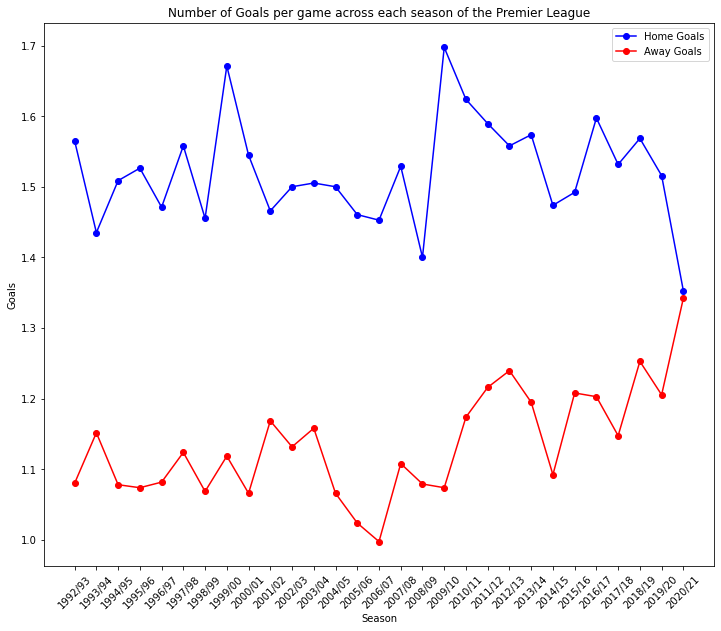

In [148]:
    plt.close('all')
    plt.figure(figsize = (12, 10))
    plt.plot(goals_data['season'], goals_data['home_goal']/goals_data['total_games'], color = 'blue', marker = 'o')
    plt.plot(goals_data['season'], goals_data['away_goal']/goals_data['total_games'], color = 'red', marker = 'o')

    plt.title('Number of Goals per game across each season of the Premier League')
    plt.ylabel('Goals')
    plt.xlabel('Season')

    plt.xticks(rotation = 45)
    plt.legend(['Home Goals', 'Away Goals'])
    plt.show()
    

In [149]:
goals_home_pre_2020 = sqldf( """
    SELECT home_score as 'home_score'
    FROM df_games
    WHERE season is not '2020/21'
""")

goals_home_2020 =sqldf( """
    SELECT home_score as 'home_score'
    FROM df_games
    WHERE season is '2020/21'
""")


away_goal_pre_2020 = sqldf("""
    SELECT away_score as 'away_score'
    FROM df_games
    WHERE season is not '2020/21'
""")

away_goal_2020 = sqldf("""
    SELECT away_score as 'away_score'
    FROM df_games
    WHERE season is '2020/21'
""")

In [150]:
print(goals_home_pre_2020.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   home_score  10886 non-null  int64
dtypes: int64(1)
memory usage: 85.2 KB
None



            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 0.011766 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


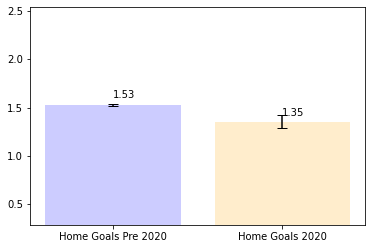

In [151]:
ttest_independent(goals_home_pre_2020['home_score'], goals_home_2020['home_score'], ['Home Goals Pre 2020', 'Home Goals 2020'])


            Null Hypothesis: There is no significant difference in the two samples.
            Alternative Hypothesis: The first and second sample are significantly different.
            

            We reject the null hypothesis as p-value of 0.001109 is less than the threshold 0.05 value. We can say
            with 95% confidence that there is a significant difference in the first sample and the second sample.
            


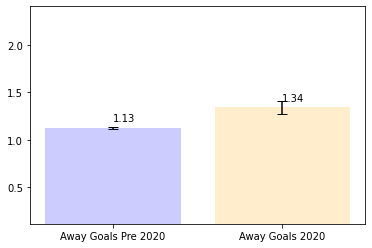

In [152]:
ttest_independent(away_goal_pre_2020['away_score'], away_goal_2020['away_score'], ['Away Goals Pre 2020', 'Away Goals 2020'])